# Target Scan to identify good spots

In [27]:
%load_ext autoreload
%autoreload 2
import numpy as np
import h5py 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

In [279]:
from scipy.interpolate import griddata

def create_grid_data(x,y,z,resolution = 10, contour_method='linear'):
    resolution = resolution
    X,Y = np.mgrid[min(x):max(x):resolution,   min(y):max(y):resolution]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method=contour_method)
    return X,Y,Z

In [257]:
from scipy.interpolate import griddata
import matplotlib.colors as colors

class TargetSignal:
    def __init__(self, fname, data_dir = 'D:/Rotational Cooling/'):
        self.fname = fname
        self.data_dir = data_dir
    
    def load_data(self, run_name):
        with h5py.File(self.data_dir+self.fname, 'r') as f:
            grp = f[run_name]
            dset = grp['readout']
            pxie = dset['PXIe-5171']
            mirror = dset['ZaberTMM'].value
            measurement_names = list(pxie.keys())[:-1]
            measurement = [int(name.split('_')[-1]) for name in measurement_names]
            indices_sort = np.argsort(measurement)
            pxie_timestamp = np.empty(len(measurement_names))
            values = np.empty([len(measurement_names), *pxie[measurement_names[0]].value.shape])
            for idx, measurement_name in enumerate(measurement_names):
                values[idx,:,:] = pxie[measurement_name].value
                pxie_timestamp[idx] = pxie[measurement_name].attrs['ch0 : timestamp']
            values = values[indices_sort,:,:]
            pxie_timestamp = pxie_timestamp[indices_sort]
            self.mirror = mirror
            self.values = values
            self.pxie_timestamp = pxie_timestamp

    @staticmethod
    def find_nearest_idx(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    def bin_signal_mirror(self, rate = 5, resolution = 10):
        values = self.values
        mirror = self.mirror
        time_pxie = np.linspace(0,len(values)-1,len(values))*1/rate+pxie_timestamp[0]
        indices_nearest = []
        for t in time_pxie:
            indices_nearest.append(self.find_nearest_idx(mirror['time'], t))
    
        bins = np.arange(0,max(indices_nearest),1)
        indices_bins = np.digitize(indices_nearest, bins)
        means = np.array([values[:,:,0][indices_bins == i].mean(axis = 0) for i in range(1,len(bins))])

        integral_all = np.trapz(values[:,400:1200,0], axis = 1)-800*np.trapz(values[:,1400:1500,0], axis = 1)/100

        x = np.array([mirror['x'][indices_nearest][indices_bins == i].mean() for i in range(1, len(bins))])
        y = np.array([mirror['y'][indices_nearest][indices_bins == i].mean() for i in range(1, len(bins))])

        # integral = np.array([integral_all[indices_bins == i].mean(axis = 0) for i in range(1,len(bins))])
        # integral[integral > 0] = 0
        # integral *= -1
        integral = np.empty(len(means))
        for idx, m in enumerate(means):
            integral[idx] = np.trapz(m[400:1500]) - 1100*np.trapz(m[1700:1950])/250

        integral[integral > 0] = 0 
        integral *= -1
        integral /= integral.max()
        
        mask = np.isfinite(integral)
        X,Y,Z = create_grid_data(x[mask], y[mask], integral[mask], resolution = resolution)
        self.X, self.Y, self.Z = X,Y,Z

        self.bins = bins
        self.indices_bins = indices_bins
        self.integral_all = integral_all
        self.x = x
        self.y = y
        self.integral = integral
        
    def plot_scan(self):       
        fig, ax = plt.subplots(figsize = (12,10))
        cax = ax.pcolormesh(self.X,self.Y,self.Z)
        vmin, vmax = cax.get_clim()
        ax.plot(self.x,self.y, 'k.')
        cbar = fig.colorbar(cax)
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_xlabel('mirror steps x')
        ax.set_ylabel('mirror steps y')
        cbar.ax.tick_params(labelsize=15)
        set_fontsize(ax, 15)
        return fig, ax

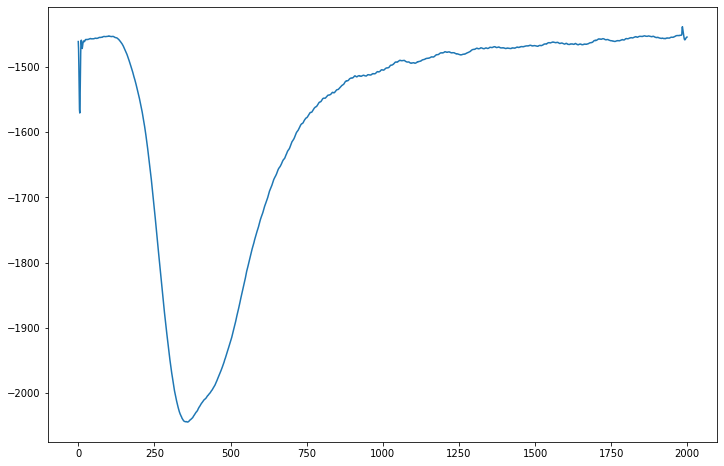

In [258]:
fname = 'target_scan_2019_12_2.hdf'
run_name = '1575329551 scanning_mirror'

scan1 = TargetSignal(fname)
scan1.load_data(run_name)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(scan1.values[:,:,0].T.mean(axis = 1));

In [275]:
scan1.bin_signal_mirror(resolution = 250)

250


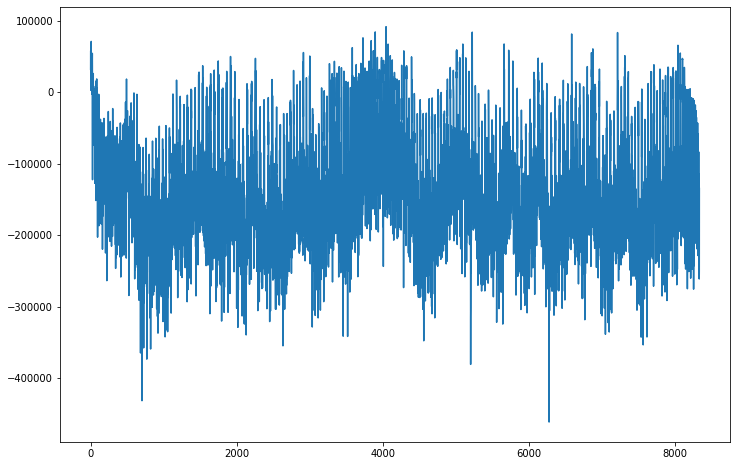

In [276]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(scan1.integral_all)

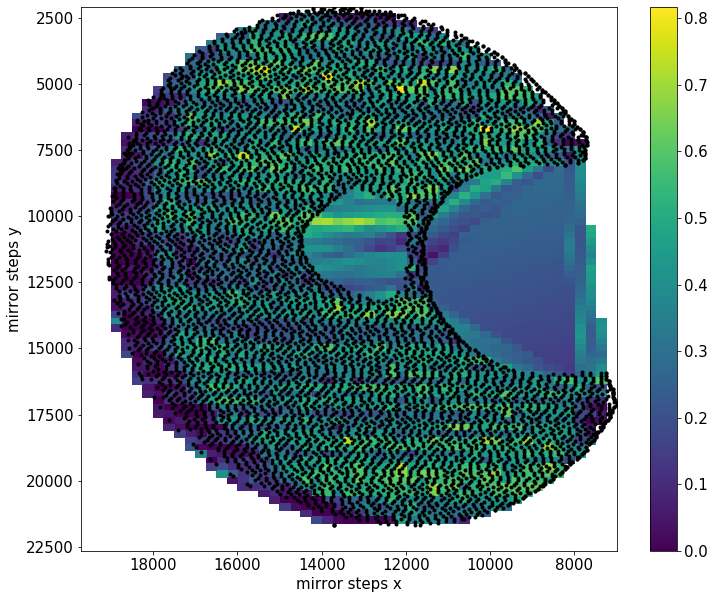

In [277]:
fig, ax = scan1.plot_scan()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


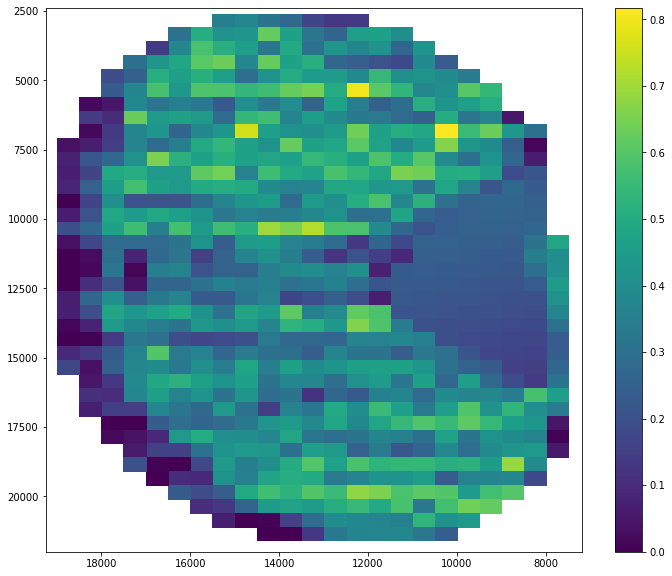

In [427]:
X,Y,Z = create_grid_data(scan1.x, scan1.y, scan1.integral, resolution = 500)
fig, ax = plt.subplots(figsize = (12,10))
# cax = ax.pcolormesh(X, Y, Z)
# cbar = fig.colorbar(cax)
ax.set_xlim(7200,19250)
ax.set_ylim(2400,22000)
ax.invert_xaxis()
ax.invert_yaxis()

mask = Z < -0.1
Zmask = Z.copy()
Zmask[mask] = np.nan
cax = ax.pcolormesh(X,Y,Zmask)
cbar = fig.colorbar(cax)

In [614]:
with h5py.File('ablation_sweeps_november2019.sweep_hdf5', 'r') as f:
    f = f['sweep01']
    coords = f.value

In [520]:
from numba import njit

@njit
def get_bad_coords(coords, x, y, dx, dy):
    coords_sanitized_index = []
    dx, dy = dx**2, dy**2
    for idx in range(len(coords)):
        cx, cy = coords[idx]
        for xi,yi in zip(x, y):
            if ((cx - xi)**2 < dx) and ((cy-yi)**2 < dy):
                coords_sanitized_index.append(idx)
                break
    return coords_sanitized_index

In [657]:
%%time
mask = scan1.integral < 0.25
indices_bad_coords = get_bad_coords(coords, scan1.x[mask], scan1.y[mask], 130,10)

Wall time: 58 ms


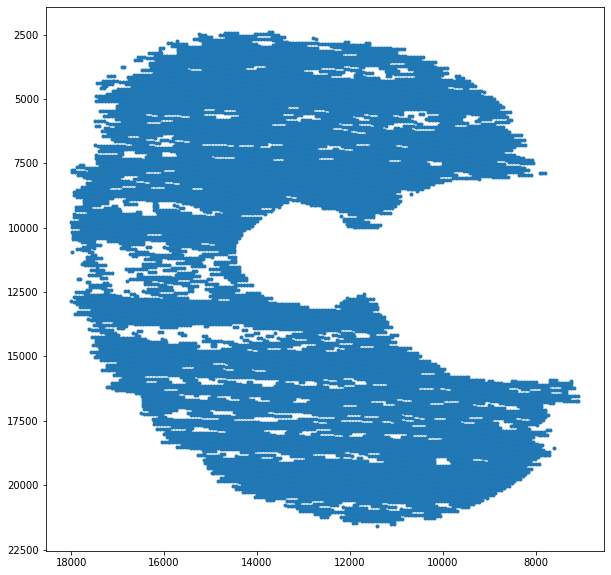

In [658]:
mask = np.ones(len(coords), dtype = bool)
mask[indices_bad_coords] = False
mask &= coords[:,0] < 18000
mask &= np.invert( (coords[:,0] < 13000) & ( coords[:,1] < 12500 ) & (coords[:,1] > 10000 ) )
mask &= np.invert( (coords[:,0] > 16500) & (coords[:,1] > 16600) )
mask &= np.invert( (coords[:,0] > 15500) & (coords[:,1] > 19300) )
mask &= np.invert( (coords[:,0] > 17500) & (coords[:,1] < 7500) )

fig, ax = plt.subplots(figsize = (10,10))

ax.plot(coords[:,0][mask], coords[:,1][mask], '.')
ax.invert_xaxis()
ax.invert_yaxis()

In [664]:
with h5py.File('ablation_sweeps_december2019.sweep_hdf5', 'w') as f:
    f.create_dataset('sweep01', data = coords[mask])

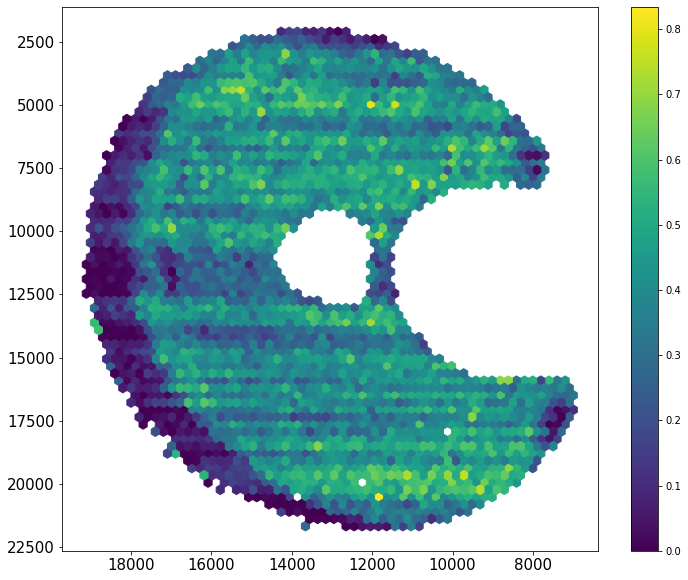

In [625]:
mask = scan1.integral > -0.1
fig, ax = plt.subplots(figsize = (12,10))
cax = ax.hexbin(scan1.x[mask], scan1.y[mask], scan1.integral[mask], gridsize = 60)
cbar = fig.colorbar(cax)
set_fontsize(ax, 15)
ax.invert_xaxis()
ax.invert_yaxis()
# ax.grid(True)